In [2]:
################## IMPORT LIBRARIES ##################

import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import matplotlib.pyplot as plt 

In [3]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import helpers as hlp
import importlib
importlib.reload(hlp);

In [4]:
np.random.seed(42)

# datapath="/media/ssd2/RESULTS-reverb-match-cond-u-net/"
datapath="/home/ubuntu/Data/"

In [24]:
# ---------- SPEECH POOL ------------

# create df with paths to speech files
speech_dataset_path1 =  pjoin(datapath,'VCTK','wav48_silence_trimmed')
speech_dataset_path2 =  pjoin(datapath,'PTDB')
speech_dataset_path3 =  pjoin(datapath,'EARS')

# initialize empty list of files:
speech_pool = []

# fill the list of files with filenames from vctk data base:
database="VCTK"
for root, dirs, files in os.walk(speech_dataset_path1):
    for file in files:
        if file.endswith('.flac'):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# fill the list of files with filenames from ptdb data base:
database="PTDB"
for root, dirs, files in os.walk(speech_dataset_path2):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if ("/MIC/" in root) & (file.endswith('.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  


# fill the list of files with filenames from ears data base:
database="EARS"
for root, dirs, files in os.walk(speech_dataset_path3):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if file.endswith(('slow.wav','fast.wav','highpitch.wav','lowpitch.wav','regular.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  


# # shuffle order
random.shuffle(speech_pool)

# turn list to data frame 
speech_pool = pd.DataFrame(speech_pool).reset_index(drop=True)
speech_pool.tail(200)
print(f"{len(speech_pool)=}")

# split speech pool into test, train and val (70/15/15)
speech_train=speech_pool[speech_pool.index<int(0.7*len(speech_pool))].reset_index(drop=True)
speech_test=speech_pool[(speech_pool.index>=int(0.7*len(speech_pool))) & (speech_pool.index<int(0.85*len(speech_pool)))].reset_index(drop=True)
speech_val=speech_pool[(speech_pool.index>=int(0.85*len(speech_pool))) & (speech_pool.index<len(speech_pool))].reset_index(drop=True)


print(f"{len(speech_train)=}")
print(f"{len(speech_test)=}")
print(f"{len(speech_val)=}")

len(speech_pool)=100322
len(speech_train)=70225
len(speech_test)=15048
len(speech_val)=15049


In [30]:
print("Separate speech pools for test, train and val:")

display(speech_train.head(5))
display(speech_test.head(5))
display(speech_val.head(5))

Separate speech pools for test, train and val:


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,PTDB,/home/ubuntu/Data/PTDB/FEMALE/MIC/F05/mic_F05_...


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,EARS,/home/ubuntu/Data/EARS/p026/sentences_02_fast.wav


In [31]:
# ---------- LOAD RIR PAIRS POOL ------------
# Here we load the info about all generated rirs ("rir_info.csv")
# Those rirs are arranged in pairs (see column "pair_nr")


rir_path=pjoin(datapath,'synth_rirs_new')

database="synth_rirs_new"
rirs_unique=pd.read_csv(pjoin(rir_path,"rir_info.csv"),index_col=0).reset_index(drop=True)
rirs_unique = rirs_unique.loc[:, ~rirs_unique.columns.str.contains('^Unnamed')]



rirs_unique.head(10)

# In rirs_ds there are 20000 rirs, which means 10000 pairs with rt60diff ~ N(0.5,02)
 
rirs_unique_train = rirs_unique[rirs_unique["pair_nr"]<7000].reset_index(drop=True)
rirs_unique_test = rirs_unique[(rirs_unique["pair_nr"]>=7000) & (rirs_unique["pair_nr"]<8500)].reset_index(drop=True)
rirs_unique_val = rirs_unique[(rirs_unique["pair_nr"]>=8500) & (rirs_unique["pair_nr"]<10000)].reset_index(drop=True)

print(f"{len(rirs_unique_train)=}")
print(f"{len(rirs_unique_test)=}")
print(f"{len(rirs_unique_val)=}")

len(rirs_unique_train)=14000
len(rirs_unique_test)=3000
len(rirs_unique_val)=3000


In [32]:
# ----- FUNCTION TO EXPAND RIR PAIRS POOL (BY FORMING NEW PAIRS) -----
# we have a dataset of 10000 rir pairs with a predefined rt60diff 
# each rir has a "clone" meaning an rir from the same room but different src pos
# so taking those into account we have 20000 pairs
# now we use each pair twice (each rir can be applied either to style or to content)
# with this, we end up with 40000 rir pairs 
# (each data point is a pair of style and content audio)

# --------- finding pairs with rt60diff ~ N(0.5,02) --------
# for each rir in this dataset, find a few additional pairs
# (but the rt60 diff should be distributed according to gauss N(0.5,02))

def expand_rir_pairs(rirs_pairs_in):
    possible_pairs = []
    mean_rt60diff=0.6
    std_rt60diff=0.2
    N_pairsperir=10
    for idx, rt60 in rirs_pairs_in["rt60_set"].items():
        # Compute differences with all other rows
        diffs = np.abs(rirs_pairs_in["rt60_set"] - rt60)

        # Exclude self-comparison
        diffs[idx] = np.nan  

        # Compute probabilities using a gauss N(0.5,02)
        probabilities = np.exp(-((diffs - mean_rt60diff) ** 2) / (2 * std_rt60diff ** 2))

        # Normalize to get a valid probability distribution
        probabilities[np.isnan(probabilities)] = 0
        probabilities /= np.nansum(probabilities)
    
        # Choose one row based on the computed probabilities
        chosen_indices = np.random.choice(diffs.index, size=N_pairsperir, p=probabilities)

        possible_pairs.append((idx, *chosen_indices))

    # --------- creating an expanded list of pairs --------
    rows=[]
    for idx in range(0, len(rirs_pairs_in)):
        # Copy rows of the pair
        row0 = rirs_pairs_in.loc[idx].copy()

        # Loop over the range of N  
        for i in range(N_pairsperir-1):
            # Use the indices from possible_pairs[idx] to get the corresponding rows
            row = rirs_pairs_in.loc[possible_pairs[idx][i+1]].copy()  # i+1 because the first element is idx
            rows.append(row0.copy())
            rows.append(row)


    rirs_pairs_out = pd.DataFrame(rows)
    rirs_pairs_out=rirs_pairs_out.reset_index(drop=True)

    # Compute absolute difference between rows
    rt60diffs = rirs_pairs_out["rt60_set"].diff().abs()

    # Assign the same difference to both rows in each pair
    rirs_pairs_out["rt60_diff"] = rt60diffs  

    # But a pair starts every second index, so we are only interested in those
    rirs_pairs_out.loc[0::2, "rt60_diff"] =rirs_pairs_out.loc[1::2, "rt60_diff"].values
    # pair number was the name of the column in the original csv from a data set 
    # it tells us from which original pair the current pair is formed, so i will leave 
    # it just in case

    rirs_pairs_out = rirs_pairs_out.rename(columns={"pair_nr": "gen_pair_nr"})


    return rirs_pairs_out

In [45]:
# ----- EXPAND TRAIN, TEST AND VAL SET ----- 
rirs_train = expand_rir_pairs(rirs_unique_train)
rirs_train["split"] = "train"

rirs_test = expand_rir_pairs(rirs_unique_test)
rirs_test["split"] = "test"

rirs_val = expand_rir_pairs(rirs_unique_val)
rirs_val["split"] = "val"

print(f"{len(rirs_train)=}")
print(f"{len(rirs_test)=}")
print(f"{len(rirs_val)=}")


len(rirs_train)=252000
len(rirs_test)=54000
len(rirs_val)=54000


In [ ]:
print("Dataframe containing rir pairs. The pairs are divided into test,train and split ((see column <split>))")
print("PAIR IS DEFINED BY TWO CONSECUTIVE ROWS idx & idx+1, where idx=range(0,N,2) (even rows start a pair)")
display(rirs_train.head(5))
display(rirs_test.head(5))
display(rirs_val.head(5))

Dataframe containing rir pairs. The pairs are divided into test,train and split ((see column <split>))
PAIR IS DEFINED BY TWO CONSECUTIVE ROWS idx & idx+1, where idx=range(0,N,2) (even rows start a pair)


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,pair_idx
0,0,0.702,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,0
1,1954,0.702,1.489,1751.86,19.68,28.50,3.12,13.854997,16.805364,1.759598,...,1.934113,4.921096,3.123527,3.455348,3.434365,-10.677782,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1968...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,0
2,0,0.428,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,1
3,3187,0.428,0.359,230.17,8.24,10.53,2.65,2.125206,4.473061,1.451563,...,1.427783,3.368793,0.554258,0.576539,0.442729,3.340666,/home/ubuntu/Data/synth_rirs_new/monoRIR_x824y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,1
4,0,0.904,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,2
5,685,0.904,1.691,3163.67,21.75,22.33,6.51,5.723583,15.097207,1.959548,...,2.439548,8.184323,2.688426,2.635829,2.144427,-3.895490,/home/ubuntu/Data/synth_rirs_new/monoRIR_x2175...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,2
6,0,0.397,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,3
7,3104,0.397,1.184,2200.10,20.16,39.17,2.79,7.376301,18.574749,1.071468,...,2.433729,4.613016,2.610534,2.949467,3.347343,-14.319973,/home/ubuntu/Data/synth_rirs_new/monoRIR_x2016...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,3
8,0,0.447,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,4
9,1411,0.447,1.234,1290.89,15.44,17.33,4.82,6.235195,8.603032,1.132002,...,1.823770,6.061724,1.987970,1.966664,1.702141,-8.143734,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1544...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,4


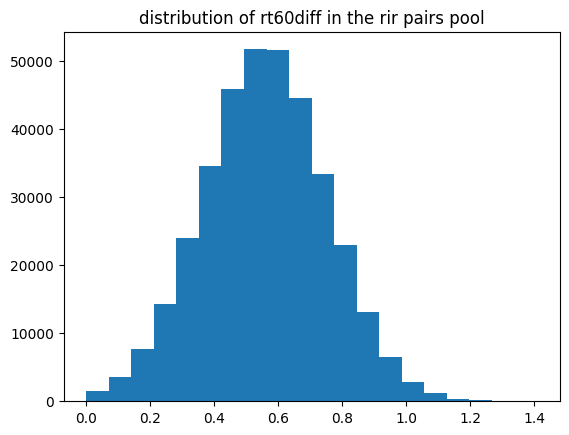

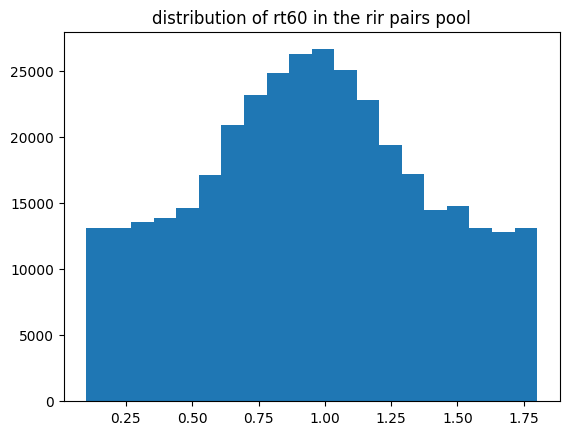

In [100]:
# plot distribution of rt60 differences in the pairs
plt.figure()
plt.hist(rirs_train"rt60_diff"],bins =20)
plt.title("distribution of rt60diff in the rir pairs pool")
plt.show()

# plot distribution of rt60 differences in the pairs
plt.figure()
plt.hist(rirs_train["rt60_set"],bins =20)
plt.title("distribution of rt60 in the rir pairs pool")
plt.show()

In [ ]:
# --------- CREATE METADATA FOR A DATASET BEING COMBINATIONS OF SPEECH AND RIRS --------
from datetime import datetime
date_tag = datetime.now().strftime("%d-%m-%Y--%H-%M")
# create dataset with 150000 data points, which consists of random combinations of speech, noise and rirs


speech_train_expanded = speech_train.sample(n=len(rirs_train), replace=True, random_state=42)
rirs_speech_train= pd.concat([rirs_train[rirs_train["split"]=="train"].reset_index(drop=True), speech_train_expanded.reset_index(drop=True)], axis=1,ignore_index=False)

speech_test_expanded = speech_test.sample(n=len(rirs_test), replace=True, random_state=42)
rirs_speech_test= pd.concat([rirs_test[rirs_test["split"]=="test"].reset_index(drop=True), speech_test_expanded.reset_index(drop=True)], axis=1,ignore_index=False)

speech_val_expanded = speech_val.sample(n=len(rirs_val), replace=True, random_state=42)
rirs_speech_val= pd.concat([rirs_val[rirs_val["split"]=="train"].reset_index(drop=True), speech_val_expanded.reset_index(drop=True)], axis=1,ignore_index=False)


# # sample from noise pool: 
# df_noise=noise_pool.sample(N_datapoints,replace=True)
# # here plan ways to augment noise data set:
# random_bool_values = [random.choice([1, -1]) for _ in range(len(df_noise))]
# df_noise["aug_phase"]=random_bool_values

# # sample from speech pool: 
# df_speech=speech_pool.sample(N_datapoints,replace=True)
# # here plan ways to augment noise data set:
# random_bool_values = [random.choice([1, -1]) for _ in range(len(df_speech))]
# df_speech["aug_phase"]=random_bool_values

# # sample from rir pool: 
# df_rir=rir_pool.sample(N_datapoints,replace=True)

# # concatenate samples from speech, noise and rir pools
# # df_ds = pd.concat([df_speech.reset_index(drop=True), df_noise.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)
# df_ds = pd.concat([df_speech.reset_index(drop=True), df_rir.reset_index(drop=True)], axis=1,ignore_index=False)

# df_ds = df_ds.reset_index(drop=True)

# # randomize snr (only high snrs)
# # df_ds["snr"]= 200 #np.random.uniform(low=10, high=30, size=len(df_ds))

# # Create test-train-val split:
# df_ds.loc[0:N_datapoints*0.8,"split"]="train" # 80% training data
# df_ds.loc[N_datapoints*0.8:N_datapoints*0.9,"split"]="test" # 10% testing data
# df_ds.loc[N_datapoints*0.9:N_datapoints,"split"]="val" # 10% validation data

# # save dataset metadata:
# # df_ds.to_csv(date_tag+"_data_set.csv")


# rirs_final= pd.concat([rirs_train, rirs_test,rirs_val], ignore_index=True).reset_index(drop=True)
# rirs_final["pair_idx"]=(rirs_final.index // 2).astype(int)


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,pair_idx,database_speech,speech_file_path
0,0,0.702,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,1954,0.702,1.489,1751.86,19.68,28.50,3.12,13.854997,16.805364,1.759598,...,3.123527,3.455348,3.434365,-10.677782,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1968...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,0,0.428,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,3187,0.428,0.359,230.17,8.24,10.53,2.65,2.125206,4.473061,1.451563,...,0.554258,0.576539,0.442729,3.340666,/home/ubuntu/Data/synth_rirs_new/monoRIR_x824y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,0,0.904,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
5,685,0.904,1.691,3163.67,21.75,22.33,6.51,5.723583,15.097207,1.959548,...,2.688426,2.635829,2.144427,-3.895490,/home/ubuntu/Data/synth_rirs_new/monoRIR_x2175...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
6,0,0.397,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,3,EARS,/home/ubuntu/Data/EARS/p046/rainbow_04_highpit...
7,3104,0.397,1.184,2200.10,20.16,39.17,2.79,7.376301,18.574749,1.071468,...,2.610534,2.949467,3.347343,-14.319973,/home/ubuntu/Data/synth_rirs_new/monoRIR_x2016...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
8,0,0.447,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
9,1411,0.447,1.234,1290.89,15.44,17.33,4.82,6.235195,8.603032,1.132002,...,1.987970,1.966664,1.702141,-8.143734,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1544...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


In [11]:
# # Change paths in the metadata from GuestXR computer: 

# df = pd.read_csv("../dataset-metadata/nonoise2_guestxr2.csv",index_col=0)

# df["speech_file_path"]=df["speech_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["noise_file_path"]=df["noise_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")
# df["ir_file_path"]=df["ir_file_path"].str.replace("/home/ubuntu/Data/","/media/ssd2/")

# df.to_csv("../dataset-metadata/nonoise2_dacom.csv",index=False)

# df.head(10)

In [12]:
# Check generate database

df = pd.read_csv("../dataset-metadata/17-05-2024--15-42_data_set.csv",index_col=0)


In [13]:
df.head(100)

,database_speech,speech_file_path,aug_phase,room_x,room_y,room_z,volume,rt60_set,mic_pos_x,mic_pos_y,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,database_rir,split
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1,10.814493,8.384743,4.682995,424.638783,0.447588,6.563892,3.201019,...,0.447572,1.737814,4.702880,0.510937,0.481242,0.397801,9.168168,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x108...,synth_rirs_mono,train
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,21.416892,20.061618,3.688619,1584.843083,0.777491,8.816590,8.991853,...,0.777463,2.547290,5.440065,1.481501,1.474584,0.662867,6.342023,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x214...,synth_rirs_mono,train
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,12.777369,10.481738,3.152150,422.164396,0.417115,7.610133,4.378013,...,0.417145,1.794826,4.074057,0.616033,0.601062,0.418212,8.612042,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x127...,synth_rirs_mono,train
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1,6.872966,4.640696,2.550688,81.355082,0.190540,4.206436,2.948903,...,0.190547,1.165779,2.655924,0.229588,0.234578,0.245114,15.697762,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x687...,synth_rirs_mono,train
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,23.710565,21.738363,3.192800,1645.661533,0.866427,12.951658,8.587307,...,0.866481,2.458758,4.982790,1.914648,1.963799,1.031423,5.629995,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x237...,synth_rirs_mono,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,6.215067,4.111804,3.845579,98.274273,0.185800,2.533622,2.185450,...,0.185808,1.297516,3.011411,0.166693,0.175208,0.243316,19.372602,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x622...,synth_rirs_mono,train
96,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/s...,1,29.904584,22.536426,4.082205,2751.171454,1.049392,16.602824,9.201017,...,1.049393,2.888782,6.196211,2.175475,2.167799,0.893655,6.900420,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x299...,synth_rirs_mono,train
97,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,6.790112,3.811883,4.796528,124.149069,0.234304,4.252338,1.421239,...,0.234317,1.298658,3.235750,0.245700,0.260149,0.259550,15.381532,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x679...,synth_rirs_mono,train
98,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,-1,7.542147,6.451940,4.749111,231.098765,0.300655,4.130169,3.190674,...,0.300643,1.564222,4.014886,0.306760,0.313075,0.309348,13.798457,/home/ubuntu/Data/synth_rirs_mono/monoRIR_x754...,synth_rirs_mono,train
